<a href="https://colab.research.google.com/github/mobarakol/Applied_Deep_Learning/blob/main/UNet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kitti Autonomous Driving Dataset: Semantic Segmentation
 <br>

<img src="https://www.cvlibs.net/datasets/kitti/images/header_semseg.png" alt="alternatetext">

<img src="https://drive.google.com/uc?id=1V2uXnfGwVx_MU3t8DRcJStu7kg3y02qM" alt="My Image" width="600">


Download and unzip

In [9]:
!gdown 1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D
!unzip -q kitti_autonomous_driving_seg.zip

Downloading...
From (original): https://drive.google.com/uc?id=1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D
From (redirected): https://drive.google.com/uc?id=1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D&confirm=t&uuid=65f2817c-cde7-4781-ae8b-e2fa5e6b4c3c
To: /content/kitti_autonomous_driving_seg.zip
100% 163M/163M [00:02<00:00, 70.0MB/s]


In [8]:
!rm -rf kitti_autonomous_driving_seg

https://drive.google.com/file/d/1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D/view?usp=sharing

training sample: 171 testing sample: 20
1st sample shape: torch.Size([3, 256, 512]) classes inside masks: tensor([ 4,  7,  8, 11, 12, 13, 17, 20, 21, 23, 24, 26, 27, 28])


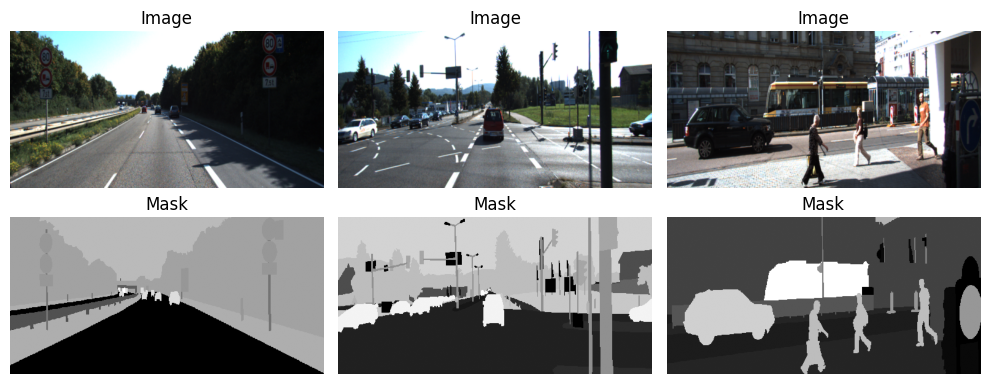

In [12]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Class names for visualization
class_names = [
    "unlabeled", "ego vehicle", "rectification border", "out of roi", "static", "dynamic", "ground", "road",
    "sidewalk", "parking", "rail track", "building", "wall", "fence", "guard rail", "bridge", "tunnel", "pole",
    "polegroup", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck",
    "bus", "caravan", "trailer", "train", "motorcycle", "bicycle"
]

class KITTISegmentationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_files = sorted(os.listdir(self.images_dir))
        self.mask_files = sorted(os.listdir(self.masks_dir))

        # Define resize transformation for both image and mask
        self.target_size=(256, 512)
        self.image_transform = transforms.Compose([
            transforms.Resize(self.target_size),  # Resize image
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Load as grayscale

        image = self.image_transform(image)
        mask = mask.resize((self.target_size[1], self.target_size[0]), resample=Image.NEAREST)

        # Convert mask to tensor without scaling
        mask = torch.from_numpy(np.array(mask)).long()
        return image, mask

# Initialize dataset and dataloader
dataset_train = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/train')
dataset_test = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/test')
dataloader_train = DataLoader(dataset_train, batch_size=12, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)
print('training sample:', len(dataset_train), 'testing sample:', len(dataset_test))
print('1st sample shape:',dataset_train[0][0].shape, 'classes inside masks:', dataset_train[0][1].unique())


# Function to display image and mask in a row
def display_image_and_mask(image, mask, ax_img, ax_mask):
    ax_img.imshow(image.permute(1, 2, 0))  # Image
    ax_img.set_title('Image')
    ax_img.axis('off')

    ax_mask.imshow(mask.squeeze(), cmap='gray')  # Mask
    ax_mask.set_title('Mask')
    ax_mask.axis('off')

# Get a batch of data
images, masks = next(iter(dataloader_train))

# Plot 3 images + masks in one row
fig, axes = plt.subplots(2, 3, figsize=(10, 4))  # 2 rows (Images & Masks), 3 columns (for 3 samples)

# Display 3 samples in one row
for i in range(3):
    display_image_and_mask(images[i], masks[i], axes[0, i], axes[1, i])

plt.tight_layout()
plt.show()

Define the U-Net Architecture

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.enc3(F.max_pool2d(e2, kernel_size=2))
        e4 = self.enc4(F.max_pool2d(e3, kernel_size=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)

        return out


Training UNet

In [14]:
import torch
import torch.nn.functional as F
import torch.optim as optim

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    intersection = 0
    union = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize to match mask size
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            intersection += (preds & masks).float().sum()
            union += (preds | masks).float().sum()

    iou = (intersection / union).item()
    avg_loss = running_loss / len(val_loader)
    return avg_loss, iou


def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    intersection = 0
    union = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Resize to match mask size
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Compute loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute IoU
        preds = torch.argmax(outputs, dim=1)
        intersection += (preds & masks).float().sum()
        union += (preds | masks).float().sum()

    iou = (intersection / union).item()
    avg_loss = running_loss / len(train_loader)
    return avg_loss, iou


# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=len(class_names)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 20
best_val_iou = 0.0
best_epoch = 0
best_model_path = './best_unet_kitti.pth'

for epoch in range(num_epochs):
    train_loss, train_iou = train_one_epoch(model, dataloader_train, criterion, optimizer)
    val_loss, val_iou = validate(model, dataloader_test, criterion)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")

    # Save best model based on IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        print(f"✅ Best model saved with IoU: {best_val_iou:.4f}, Best epoch: {best_epoch}\n")

print("Training complete.")

Epoch [1/20]
Train Loss: 3.0072, Train IoU: 0.4694
Validation Loss: 3.3718, Validation IoU: 0.3498
✅ Best model saved with IoU: 0.3498

Epoch [2/20]
Train Loss: 2.3959, Train IoU: 0.6788
Validation Loss: 3.0243, Validation IoU: 0.4535
✅ Best model saved with IoU: 0.4535

Epoch [3/20]
Train Loss: 2.1066, Train IoU: 0.7208
Validation Loss: 2.6484, Validation IoU: 0.6971
✅ Best model saved with IoU: 0.6971

Epoch [4/20]
Train Loss: 1.9431, Train IoU: 0.7404
Validation Loss: 1.7644, Validation IoU: 0.7514
✅ Best model saved with IoU: 0.7514

Epoch [5/20]
Train Loss: 1.8247, Train IoU: 0.7578
Validation Loss: 1.6769, Validation IoU: 0.7609
✅ Best model saved with IoU: 0.7609

Epoch [6/20]
Train Loss: 1.7216, Train IoU: 0.7676
Validation Loss: 1.6735, Validation IoU: 0.7609
Epoch [7/20]
Train Loss: 1.6315, Train IoU: 0.7836
Validation Loss: 1.6202, Validation IoU: 0.7614
✅ Best model saved with IoU: 0.7614

Epoch [8/20]
Train Loss: 1.5926, Train IoU: 0.7815
Validation Loss: 1.5427, Validatio

Inference on Best Model

<ipython-input-17-36d0716fd9c3>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Best model loaded with IoU: 0.8143

Mean IoU: 0.8096
Mean Dice: 0.8903


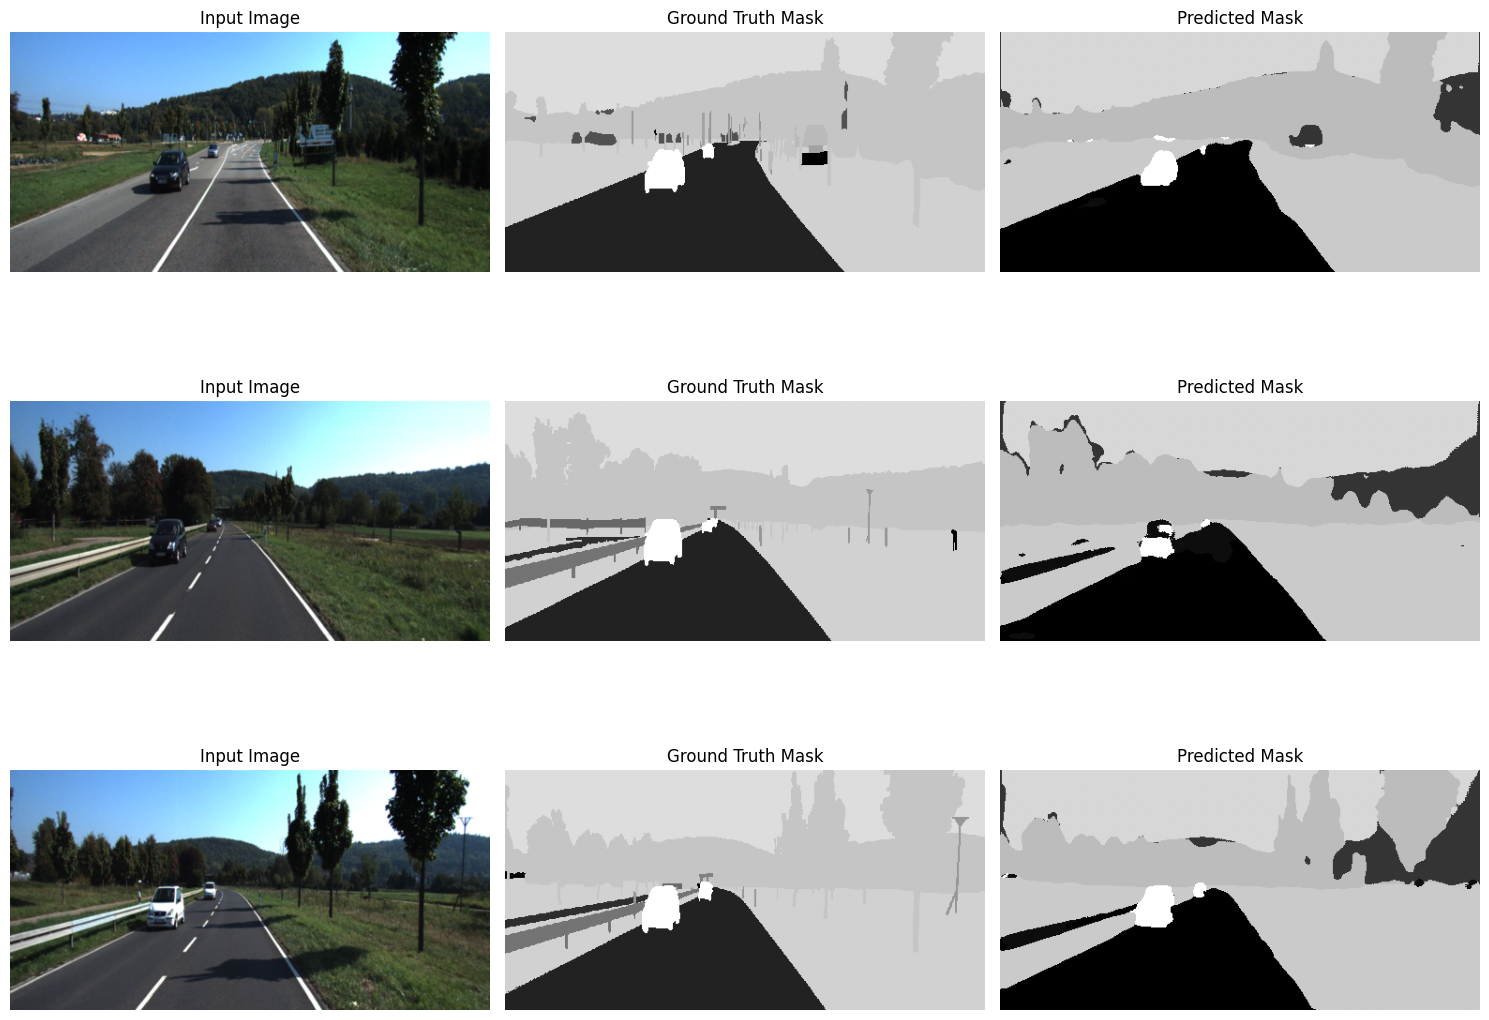

In [17]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def calculate_metrics(pred, mask):
    intersection = (pred & mask).float().sum()
    union = (pred | mask).float().sum()
    iou = intersection / union if union > 0 else torch.tensor(0.0)

    dice = (2. * intersection) / (pred.float().sum() + mask.float().sum()) if (pred.float().sum() + mask.float().sum()) > 0 else torch.tensor(0.0)

    return iou.item(), dice.item()

def inference(model, dataloader_test):
    model.eval()

    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, masks in dataloader_test:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            preds = torch.argmax(outputs, dim=1)

            # Calculate IoU and Dice for each sample in the batch
            for i in range(images.size(0)):
                iou, dice = calculate_metrics(preds[i], masks[i])
                total_iou += iou
                total_dice += dice

            num_samples += images.size(0)

    # Compute mean IoU and Dice
    mean_iou = total_iou / num_samples
    mean_dice = total_dice / num_samples

    print(f"\nMean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")

    # Plot 3 samples, corresponding masks, and predictions
    images, masks = next(iter(dataloader_test))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    for i in range(3):
        # Input Image
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(preds[i].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Best model loaded with IoU: {best_val_iou:.4f}")

# Run inference
inference(model, dataloader_test)


#Uncertainty-based Weakly-Supervised Learning

Pseudo-Label Generator:

1. Calculate uncertainty using the softmax entropy.
2. Only retain labels with entropy below a certain threshold.
3. Save the filtered pseudo-labels to disk.





In [27]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Paths
unlabelled_path = '/content/kitti_autonomous_driving_seg/unlabel'
pseudo_label_path = '/content/kitti_autonomous_driving_seg/pseudo_labels'
os.makedirs(pseudo_label_path, exist_ok=True)

# Load the trained model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Define transformation (same as training)
image_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])

# Step 1: Compute the 60th percentile of entropy across all pixels
def compute_uncertainty_threshold():
    all_entropy = []
    files = sorted(os.listdir(unlabelled_path))
    print(f"Computing entropy for {len(files)} images to determine threshold...")

    model.eval()
    for file in tqdm(files):
        img_path = os.path.join(unlabelled_path, file)
        image = Image.open(img_path).convert('RGB')
        image = image_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            output = F.interpolate(output, size=(256, 512), mode='bilinear', align_corners=False)
            probs = F.softmax(output, dim=1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-7), dim=1)  # Compute entropy

            # Flatten entropy map and store values
            entropy = entropy.squeeze(0).view(-1).cpu().numpy()
            all_entropy.extend(entropy)

    # Compute 60th percentile threshold to exclude top 40% most uncertain pixels
    threshold = np.percentile(all_entropy, 60)
    print(f"\n✅ Computed uncertainty threshold at 60th percentile: {threshold:.4f}\n")
    return threshold

# Step 2: Generate pseudo-labels based on computed threshold
def generate_pseudo_labels(threshold):
    model.eval()
    files = sorted(os.listdir(unlabelled_path))
    print(f"Generating pseudo-labels for {len(files)} images...")

    for file in tqdm(files):
        img_path = os.path.join(unlabelled_path, file)
        image = Image.open(img_path).convert('RGB')
        image = image_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            output = F.interpolate(output, size=(256, 512), mode='bilinear', align_corners=False)
            probs = F.softmax(output, dim=1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-7), dim=1)  # Compute entropy

            # Get predicted mask
            mask = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()
            entropy = entropy.squeeze(0).cpu().numpy()

            # Print stats for debugging
            print(f"Max entropy: {entropy.max():.4f}, Min entropy: {entropy.min():.4f}")
            print('Predicted Classes Before Filtering:', np.unique(mask))

            # Apply threshold-based filtering (high entropy = ignore)
            mask[entropy > threshold] = 255  # 255 = Ignore label

            print('Predicted Classes After Filtering:', np.unique(mask))

            # Save pseudo label
            pseudo_mask = Image.fromarray(mask.astype(np.uint8))
            pseudo_mask.save(os.path.join(pseudo_label_path, file))

# Step 3: Compute threshold and generate pseudo-labels
UNCERTAINTY_THRESHOLD = compute_uncertainty_threshold()
generate_pseudo_labels(UNCERTAINTY_THRESHOLD)


<ipython-input-27-5491a4c2877e>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Computing entropy for 9 images to determine threshold...


100%|██████████| 9/9 [00:00<00:00, 13.71it/s]



✅ Computed uncertainty threshold at 60th percentile: 2.4726

Generating pseudo-labels for 9 images...


 22%|██▏       | 2/9 [00:00<00:00, 15.51it/s]

Max entropy: 3.4942, Min entropy: 1.1979
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.4955, Min entropy: 1.1219
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.4933, Min entropy: 1.2272
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.4833, Min entropy: 1.0301
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]


 67%|██████▋   | 6/9 [00:00<00:00, 15.01it/s]

Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.4947, Min entropy: 0.9745
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.5002, Min entropy: 1.2659
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]


100%|██████████| 9/9 [00:00<00:00, 14.33it/s]

Max entropy: 3.5058, Min entropy: 1.2447
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.5119, Min entropy: 1.0823
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]
Max entropy: 3.4878, Min entropy: 0.8402
Predicted Classes Before Filtering: [ 7  8 11 21 22 23 26]
Predicted Classes After Filtering: [  7   8  11  21  22  23  26 255]


Create Pseudo-Labeled Dataset

In [28]:
class KITTISegmentationDatasetWithPseudo(Dataset):
    def __init__(self, root_dir, pseudo_dir=None):
        self.root_dir = root_dir
        self.pseudo_dir = pseudo_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')

        self.image_files = sorted(os.listdir(self.images_dir))
        self.mask_files = sorted(os.listdir(self.masks_dir))

        if pseudo_dir:
            pseudo_img_files = sorted(os.listdir('/content/kitti_autonomous_driving_seg/unlabel'))
            pseudo_mask_files = sorted(os.listdir('/content/kitti_autonomous_driving_seg/pseudo_labels'))
            self.image_files.extend(pseudo_img_files)
            self.mask_files.extend(pseudo_mask_files)

        # Define resize transformation for both image and mask
        self.target_size = (256, 512)
        self.image_transform = transforms.Compose([
            transforms.Resize(self.target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if idx < len(os.listdir(self.images_dir)):
            img_path = os.path.join(self.images_dir, self.image_files[idx])
            mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        else:
            img_path = os.path.join(unlabelled_path, self.image_files[idx])
            mask_path = os.path.join(pseudo_label_path, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image = self.image_transform(image)
        mask = mask.resize((self.target_size[1], self.target_size[0]), resample=Image.NEAREST)

        mask = torch.from_numpy(np.array(mask)).long()

        # Set high-entropy ignored regions to ignore index
        mask[mask == 255] = -1  # -1 is the ignore index in CrossEntropyLoss

        return image, mask

# Create combined dataset with pseudo labels
dataset_train = KITTISegmentationDatasetWithPseudo(
    root_dir='/content/kitti_autonomous_driving_seg/train',
    pseudo_dir=pseudo_label_path
)

dataloader_train = DataLoader(dataset_train, batch_size=12, shuffle=True)


Fine-Tuning Loop

Fine-tune the model using the new dataset.

Continue saving the best model based on validation IoU.

In [29]:
import torch.optim as optim

# Fine-tuning settings
fine_tune_epochs = 10
learning_rate = 5e-5  # Smaller learning rate for fine-tuning

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore high-entropy areas

# Load the trained model
model.load_state_dict(torch.load(best_model_path))
best_model_path_pseudo = './best_unet_kitti_pseudo.pth'

for epoch in range(fine_tune_epochs):
    train_loss, train_iou = train_one_epoch(model, dataloader_train, criterion, optimizer)
    val_loss, val_iou = validate(model, dataloader_test, criterion)

    print(f"Epoch [{epoch + 1}/{fine_tune_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with IoU: {best_val_iou:.4f}\n")

print("Fine-tuning complete.")


<ipython-input-29-7508b360a44d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Epoch [1/10]
Train Loss: 1.0274, Train IoU: 0.8680
Validation Loss: 1.1473, Validation IoU: 0.7901
Epoch [2/10]
Train Loss: 0.9889, Train IoU: 0.8762
Validation Loss: 1.0574, Validation IoU: 0.8227
✅ Best model saved with IoU: 0.8227

Epoch [3/10]
Train Loss: 0.9694, Train IoU: 0.8746
Validation Loss: 1.0666, Validation IoU: 0.8300
✅ Best model saved with IoU: 0.8300

Epoch [4/10]
Train Loss: 0.9351, Train IoU: 0.8846
Validation Loss: 1.0423, Validation IoU: 0.8331
✅ Best model saved with IoU: 0.8331

Epoch [5/10]
Train Loss: 0.9149, Train IoU: 0.8869
Validation Loss: 1.0723, Validation IoU: 0.8152
Epoch [6/10]
Train Loss: 0.8889, Train IoU: 0.8905
Validation Loss: 1.0114, Validation IoU: 0.8433
✅ Best model saved with IoU: 0.8433

Epoch [7/10]
Train Loss: 0.8704, Train IoU: 0.8926
Validation Loss: 1.0119, Validation IoU: 0.8262
Epoch [8/10]
Train Loss: 0.8493, Train IoU: 0.8975
Validation Loss: 0.9625, Validation IoU: 0.8317
Epoch [9/10]
Train Loss: 0.8369, Train IoU: 0.8961
Validatio

Inference and Final Testing

<ipython-input-30-a08ecb6c449b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Final Test Loss: 1.0195, Test IoU: 0.8433

Mean IoU: 0.8377
Mean Dice: 0.9083


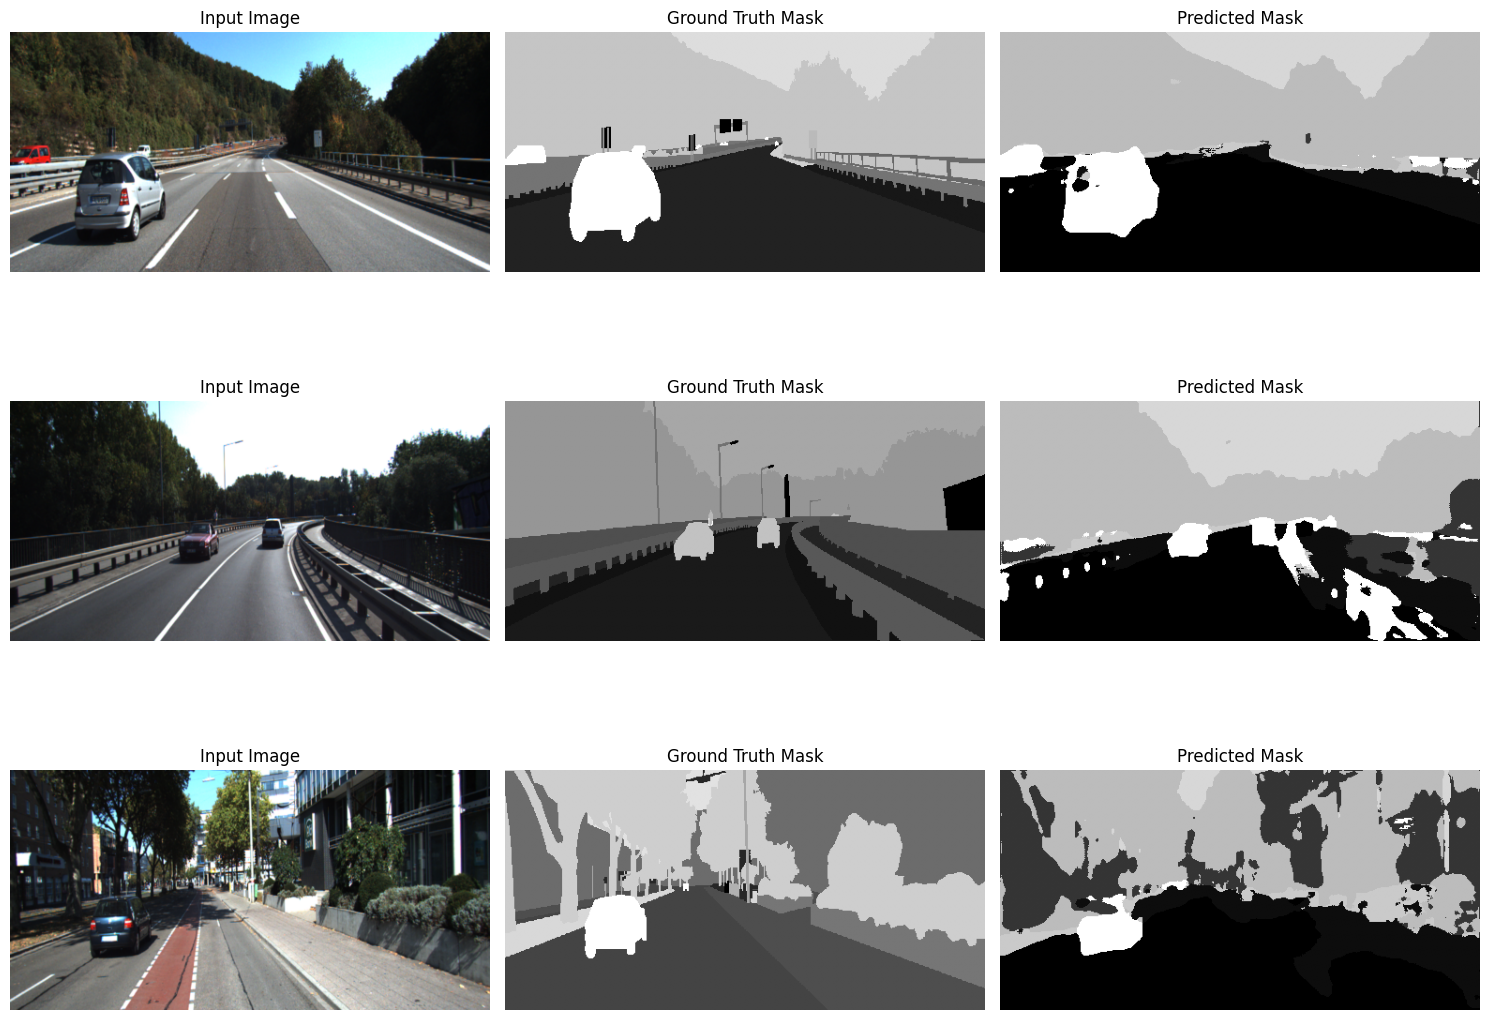

In [30]:
# Load best model and test
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_loss, test_iou = validate(model, dataloader_test, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}")

inference(model, dataloader_test)
